In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# import requests
# import zipfile
# import os

# # Setup a data folder
# data_path = "SRCNN"
# image_path = os.path.join(data_path, "Data")

# # If the image folder doesn't exist, download it and prepare it...
# if os.path.exists(image_path):
#     print(f"{image_path} directory already exists....skipping download")
# else:
#     print(f"{image_path} doesn't exist...creating one")
#     os.makedirs(image_path)

# # Download the data from GitHub
# zip_file_path = os.path.join(data_path, "Data.zip")
# github_url = "https://github.com/Lelouch-Britannia/SRCNN/raw/master/Data.zip"

# with open(zip_file_path, "wb") as f:
#     print("Downloading HR train and test images...")
#     response = requests.get(github_url)
#     f.write(response.content)

# # Unzip data
# with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
#     print("Unzipping HR train and test images.....")
#     zip_ref.extractall(image_path)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


SRCNN/Data doesn't exist...creating one
Unzipping HR train and test images.....


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib as Path
import torch
import os

/home/mpershad/Documents/Python/SRCNN/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1.0 Image Quality Metrics

1. Mean Squared Error(MSE) :  MSE loss function is evaluated only by the difference between the central pixels of Xi and the network output.

$$
L(\Theta) = \frac{1}{n} \sum_{i=1}^n \left \| F(Y_i; \Theta) - X_i \right \|^2,
$$

where n is the number of training examples. Using MSE as the loss functiion favors a high PSNR.

Alternative evaluation metrics,

1. Peak Signal To Noise Ratio(PSNR)

2. Structural Similarity Index(SSIM)

## 1.1 Mean Squared Error(MSE)

In [3]:
import numpy as np

def mse(original : np.ndarray, target : np.ndarray) -> float:

  """
  Compute the Mean Squared Error (MSE) between two images.

  Parameters:
  original (np.ndarray): The original image, expected to be a numpy array.
  compressed (np.ndarray): The compressed or modified image, expected to be a numpy array.

  Returns:
  float: The MSE value.
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  return mse

## 1.2 Peak Signal To Noise Ratio(PSNR)

In [4]:
import numpy as np

def psnr(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Peak Signal to Noise Ratio (PSNR) between two images.

  Parameters:
  original (numpy.ndarray): The original image.
  compressed (numpy.ndarray): The compressed or modified image.

  Returns:
  float: The PSNR value in decibels (dB).
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  if mse == 0:
    # MSE is zero means no noise is present in the signal.
    # Therefore, PSNR is infinite.
    return float('inf')

  max = 255.0
  psnr_val = 20*np.log10(max / np.sqrt(mse))
  return psnr_val

## 1.4 Structural Similarity Index(SSIM)

In [5]:
from skimage.metrics import structural_similarity as ssim_lib
from skimage.color import rgb2gray
import numpy as np

def ssim(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Structural Similarity Index (SSIM) between two images.

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Returns:
  float: The SSIM value.
  """

  # Convert images to grayscale if they are in color because SSIM is often computed in grayscale
  if original.ndim == 3:
    original = rgb2gray(original)
  if target.ndim == 3:
    target = rgb2gray(target)
    
  # Dynamically determine the data range for SSIM calculation
  # If the images are floating point, assume they are in [0, 1]
  if original.dtype == np.float32 or original.dtype == np.float64:
      data_range = 1
  else:
      # For integer types, use the maximum possible value of the dtype
      data_range = np.iinfo(original.dtype).max
  
  ssim_value, _ = ssim_lib(original, target, data_range=data_range, full=True)
  return ssim_value

## 1.3 Custom Peak Signal To Noise Ratio(PSNR)

In [6]:
import numpy as np

def custom_psnr(output, target) -> float:
    """
    Compute the Peak Signal to Noise Ratio (PSNR) focusing on the central region of the images.

    Parameters:
    output (torch.Tensor): The output from the model.
    target (torch.Tensor): The target high-resolution images.

    Returns:
    float: The computed PSNR value in decibels (dB).
    """

    # Calculate the difference in size between the target and the output
    delta_h = output.shape[0] - target.shape[0]
    delta_w = output.shape[1] - target.shape[1]

    # Calculate the start and end indices for cropping
    start_height = delta_h // 2
    end_height = start_height + target.shape[0]
    start_width = delta_w // 2
    end_width = start_width + target.shape[1]

    # Crop the central region of the target to match the output size
    output_cropped = output[start_height:end_height, start_width:end_width, :]

    # Compute MSE loss
    mse_loss = np.mean((output_cropped - target) ** 2)
    if mse_loss == 0:
        return float('inf')

    max_pixel = 1.0  # Assuming the tensors are scaled between 0 and 1
    psnr_val = 20 * np.log10(max_pixel / np.sqrt(mse_loss))

    return psnr_val.item()

## 1.5 Custom MSE

In [7]:
import numpy as np

def custom_mse_loss(output, target):
    """
    Compute the Mean Squared Error (MSE) focusing on the central region of the images.

    Parameters:
    output (torch.Tensor): The output from the model.
    target (torch.Tensor): The target high-resolution images.

    Returns:
    torch.Tensor: The computed MSE loss.
    """
    # Assuming output and target are both 4D tensors of shape [batch_size, channels, height, width]
    # First, we need to calculate the central region of the target to match the output size

    # Calculate the difference in size between the target and the output
    delta_h = output.shape[0] - target.shape[0]
    delta_w = output.shape[1] - target.shape[1]

    # Calculate the start and end indices for cropping
    start_height = delta_h // 2
    end_height = start_height + target.shape[0]
    start_width = delta_w // 2
    end_width = start_width + target.shape[1]

    # Crop the central region of the target to match the output size
    output_cropped = output[start_height:end_height, start_width:end_width, :]

    # Compute MSE loss
    mse_loss = np.mean((output_cropped - target) ** 2)

    return mse_loss

## 1.6 Combined Metric

In [8]:
from typing import Tuple
import numpy as np

def combined_metric(original : np.ndarray, target : np.ndarray) -> Tuple:
  """
  Combined metric using MSE, PSNR and SSIM

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Return:
  Tuple: (MSE, PSNR, SSIM)
  """

  mse_val = mse(original, target)
  psnr_val = psnr(original, target)
  ssim_val = ssim(original, target)

  return (mse_val, psnr_val, ssim_val)

# 2.0 Becoming one with the data(Pre Process and Explore)

In [9]:
def walk_through_dir(path : str) -> None:
  """
  Walk through Directory returning its content
  """

  for dirpath, dirname, filenames in os.walk(path):
    print(f"There are {len(filenames)} images in the {dirpath}")

In [10]:
image_path = 'SRCNN/Data/Train'
walk_through_dir(image_path)

## 2.1 Visualizing the data

1. Get all the image paths
2. Pick a random image using `np.random.randint()`
3. Since we're working with images, let's open image with matplotlib
4. Show Image with Metadata

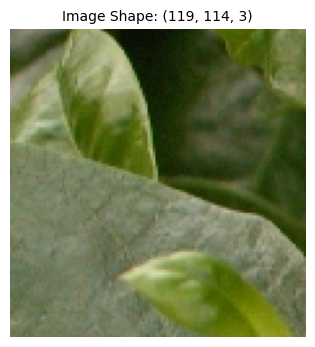

In [11]:
from PIL import Image
from pathlib import Path

# np.random.seed(42)

# Get posix path
image_path = '../Data/Train'
image_path = Path(os.path.join(image_path, "HR"))

# 1. Get all the image path
image_path = list(image_path.glob("*.bmp"))

# 2. Pick a radom image path
idx = np.random.randint(0, len(image_path))
random_img_path = image_path[idx]

# 3. Open Image
# random_img = plt.imread(random_img_path)
random_img = Image.open(random_img_path).convert('RGB')
random_img = np.array(random_img)

# Plot using matplotlib
plt.figure(figsize=(6,4))
plt.imshow(random_img)
plt.title(f"Image Shape: {random_img.shape}", fontsize=10) # shape: [height, width, color_chnanel]
plt.axis("off")
plt.show()

# 3.0 Transforming Data

To prepare our dataset for training a Super-Resolution CNN (SRCNN), we need to simulate low-resolution (LR) images from our high-resolution (HR) images. The following steps are taken for each image in our HR dataset:

1. **Apply Gaussian Blur**:
   A Gaussian blur is applied to the HR images. This step is performed to smooth out the images and simulate the loss of detail that occurs in a real-world low-resolution image.

2. **Downscale**:
   The blurred HR images are then downsampled by a specified upscale factor.

3. **Upscale**:
   The downsampled images are then upscaled back to the original dimensions using bicubic interpolation.

4. **Save Processed Images**:
  The processed LR images are saved back to the filesystem for use in training the SRCNN.


## 3.0.1 LR Transformations

In [12]:
# Hyperparameters for Gaussian Blur
kernel_size = (5, 5)
sigma = 0.5
scale = 3

In [13]:
import cv2 as cv
import numpy as np
from typing import Tuple

def generate_lr_image(image: np.ndarray, operation: str, scale: int, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0) -> np.ndarray:
  """
  Processes the low-resolution image based on the specified operation: Gaussian Blur, Down-and-Up sampling, or both,
  for both grayscale and color images.

  Parameters:
  - image (np.ndarray): The input image to process. Can be grayscale or color.
  - operation (str): The operation to perform - 'blur', 'downup', 'both'.
  - scale (int): The downscaling factor for down-and-up sampling.
  - kernel_size (Tuple[int, int]): The kernel size for Gaussian blur.
  - sigma (float): The sigma value for Gaussian blur.

  Returns:
  - np.ndarray: Low-resolution image.
  """
  # Check if the image is grayscale or color
  if len(image.shape) == 2:
    # Grayscale image
    h, w = image.shape
  else:
    # Color image
    h, w, _ = image.shape

  lr_image = image

  if operation in ['blur', 'both']:
    # Apply Gaussian Blur
    lr_image = cv.GaussianBlur(lr_image, kernel_size, sigma)

  if operation in ['downup', 'both']:
    # Downscale and then upscale
    if len(image.shape) == 2:
      # Grayscale
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)
    else:
      # Color
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)

  return lr_image

In [29]:
operation = input("Enter the operation that needs to performed on HR Image: ")

# Print message about the processing type
if operation == 'blur':
    print(f"Applying Gaussian Blur with kernel size {kernel_size} and sigma {sigma}.")
elif operation == 'downup':
    print("Applying Down-and-Up sampling.")
elif operation == 'both':
    print(f"Applying both Gaussian Blur with kernel size {kernel_size} and sigma {sigma}, and Down-and-Up sampling.")

Applying Down-and-Up sampling.


In [30]:
# Setup train Paths
image_path = '../Data/Train'
hr_train_path = os.path.join(str(image_path), "HR")
# lr_train_path = os.path.join(str(image_path), "LR")
hr_train_path

'../Data/Train/HR'

In [31]:
# Setup test Paths
test_image_path = '../Data/Test'
hr_test_path = os.path.join(str(test_image_path), "HR")
# lr_test_path = os.path.join(str(test_image_path), "LR")
hr_test_path

'../Data/Test/HR'

In [32]:
from PIL import Image

def plot_hr_lr_images(hr_img_dir: str, n: int = 3, seed=52):
  if seed:
    np.random.seed(seed)

  plt.figure(figsize=(10, 10))

  random_idx_list = list(np.random.randint(0, len(os.listdir(hr_img_dir)), n))

  for i, idx in enumerate(random_idx_list):
    hr_img_path = os.path.join(hr_img_dir, os.listdir(hr_img_dir)[idx])
    # lr_img_path = os.path.join(lr_img_dir, os.listdir(lr_img_dir)[idx])

    # hr_img = plt.imread(hr_img_path)
    # lr_img = plt.imread(lr_img_path)

    hr_img = Image.open(hr_img_path).convert('RGB')
    # lr_img = Image.open(lr_img_path).convert('RGB')

    hr_img = np.array(hr_img)

    lr_img = generate_lr_image(hr_img, operation, scale, kernel_size, sigma)
    
    metrics = combined_metric(hr_img, lr_img)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(hr_img)
    plt.title(f"HR Image\nSize: {hr_img.shape}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(lr_img)
    plt.title(f"LR Image\nSize: {lr_img.shape}", fontsize=8)
    plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
    plt.xticks([])
    plt.yticks([])
    # plt.axis("off")

  plt.tight_layout()
  plt.show()

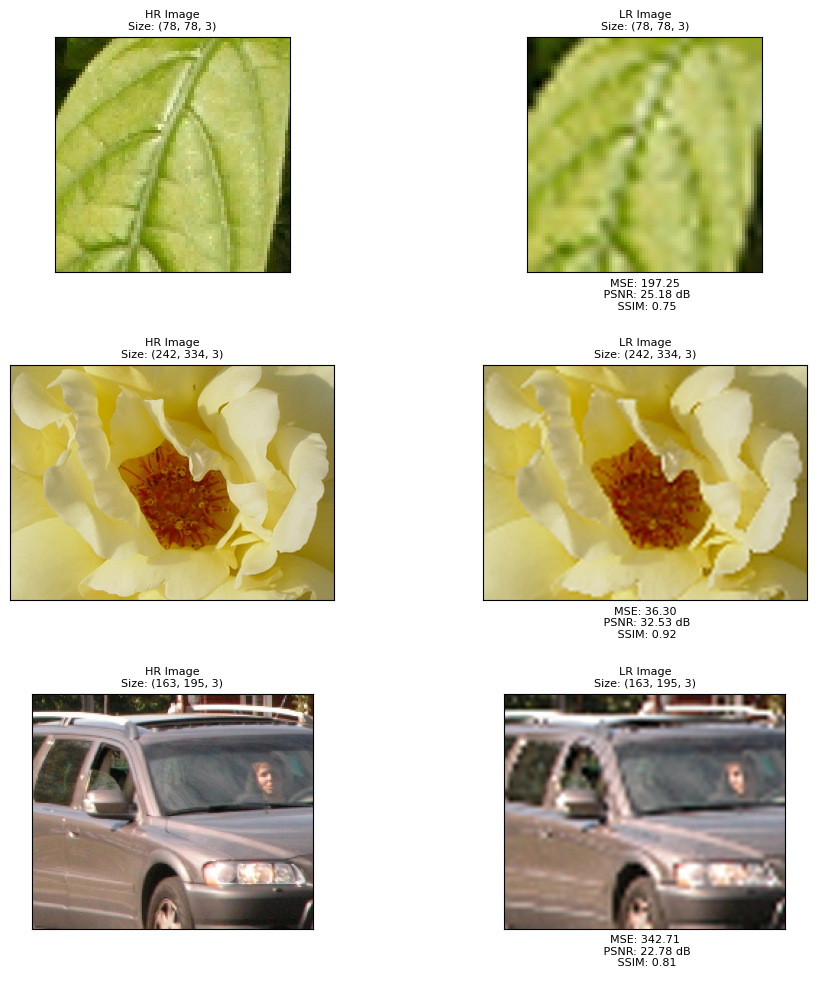

In [33]:
plot_hr_lr_images(hr_img_dir = hr_train_path,
                  n = 3)

## 3.1 Architecture

In [19]:
arch_input = input("Enter the SRCNN architecture as comma-separated filter sizes (e.g., '9,1,5'): ")
arch = [int(x.strip()) for x in arch_input.split(',')]

## 3.2 Modcrop

In [34]:
def modcrop(img, modulo):

  if img.ndim == 2:
    sz = img.shape
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1]]
  elif img.ndim == 3:
    sz = img.shape[0:2]
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1], :]
  else:
    raise ValueError("Unsupported image dimensions")

  return img_cropped

## 3.3 Sub Images using different blurring options(From Authors)

In [35]:
import os
import sys
import cv2 as cv
import numpy as np
import argparse
from PIL import Image
from typing import Tuple

def generate_patches(filepath: str, patches_label_dir: str, patches_data_dir: str, operation: str, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0, size_input:int = 33, size_label:int = 21, scale:int = 3, stride:int = 14):
  """
  Generates training patches from a single image file and saves them to specified directories.

  This function takes an image file, processes it to generate low-resolution (LR) and high-resolution (HR) patches, and saves these patches as individual image files in specified directories. LR patches are generated by downsampling and then upsizing the original HR image using bicubic interpolation. The function then extracts patches of specified sizes from both the LR and HR images using a specified stride.

  Parameters:
  - filename (str): Path to the original HR image file.
  - patches_label_dir (str): Directory path where HR (label) patches will be saved.
  - patches_data_dir (str): Directory path where LR (input/data) patches will be saved.
  - size_input (int, optional): Size of the LR patches. Default is 33.
  - size_label (int, optional): Size of the HR patches. Default is 21.
  - scale (int, optional): Factor by which the HR image is downsampled to generate the LR image. Default is 3.
  - stride (int, optional): Stride with which patches are extracted from the images, controlling the overlap. Default is 14.

  Returns:
  - int: The total number of patches generated from the image.

  Raises:
  - TypeError: If the input image is not a PIL Image object.
  """
  # Create directories for patches if they don't exist
  os.makedirs(patches_label_dir, exist_ok=True)
  os.makedirs(patches_data_dir, exist_ok=True)

  filename = os.path.basename(filepath).split('.')[0]

  padding = (size_input - size_label) // 2

  img = Image.open(filepath).convert('RGB')

  if not isinstance(img, Image.Image):
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

  img_ycbcr = img.convert('YCbCr')

  # Convert images to numpy arrays
  img = np.array(img_ycbcr)

  # Take the y channel
  y_channel = img[:, :, 0]

  im_label = modcrop(y_channel, scale)
  h, w = im_label.shape
  total_patches = 0

  # Process the image for low-resolution version
  im_input = generate_lr_image(im_label, operation, scale, kernel_size, sigma)

  # Save each patch to the respective directories
  for x in range(0, h-size_input+1, stride):
    for y in range(0,  w-size_input+1, stride):
      # Extract the data and label patch
      data_patch = im_input[x:x+size_input, y:y+size_input]
      label_patch = im_label[x+padding:x+padding+size_label, y+padding:y+padding+size_label]

      # Convert patches back to images
      data_patch_img = Image.fromarray(data_patch)
      label_patch_img = Image.fromarray(label_patch)

      total_patches += 1

      # Save the patch
      data_patch_img.save(os.path.join(patches_data_dir, f'{filename}_{x}_{y}.png'))
      label_patch_img.save(os.path.join(patches_label_dir, f'{filename}_{x}_{y}.png'))

  return total_patches

In [ ]:
# Generating training data

train_data_dir = "../Data/Train/HR"
size_input = 33
size_label = size_input - sum([f - 1 for f in arch])
stride = 14

total = 0
for filename in os.listdir(train_data_dir):
  filepath = os.path.join(train_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Train/pHR',
            patches_data_dir='../Data/Train/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            size_label=size_label,
            scale=scale,
            stride=stride)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

In [ ]:
# Generating Validation data

validation_data_dir = "../Data/Test/HR"
size_input = 33
size_label = size_input - sum([f - 1 for f in arch])
stride = 21

total = 0
for filename in os.listdir(validation_data_dir):
  filepath = os.path.join(validation_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Validation/pHR',
            patches_data_dir='../Data/Validation/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            size_label=size_label,
            scale=scale,
            stride=stride)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

## 3.4 Plot image and patches

In [38]:
import numpy as np
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt

def plot_image_with_all_patches(img_path: str, patch_size: tuple, step: int) -> None:
  """
  Generates patches for an image using patchify and plots them alongside the original image.

  Parameters:
  img_path (str): Path to the image file.
  patch_size (tuple): The size of the patches (width, height).
  step (int): The step size for the sliding window when patchifying.
  """
  # Load the image
  img = Image.open(img_path)
  img_array = np.array(img)

  # Generate patches
  patches = patchify(img_array, patch_size + (3,), step=step)

  # Calculate the layout for plotting
  num_patches = patches.shape[0] * patches.shape[1]
  num_columns = patches.shape[1]
  num_rows = patches.shape[0]

  # Plot the original image
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.title(f"Size: {img_array.shape}", fontsize=8)
  plt.axis('off')
  # plt.show()

  # Create a new figure for patches
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(5, 5))

  # Ensure we have a 2D axes array for single row/column
  if num_rows == 1 or num_columns == 1:
    axes = np.array(axes).reshape(num_rows, num_columns)

  # Plot each patch
  for i in range(num_rows):
    for j in range(num_columns):
        patch_img = patches[i, j, 0]
        axes[i, j].imshow(patch_img)
        axes[i, j].axis('off')

  # Adjust the spacing
  plt.subplots_adjust(wspace=0.1, hspace=0.05)
  # Alternatively, you can use tight_layout with parameters
  # plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

  plt.show()

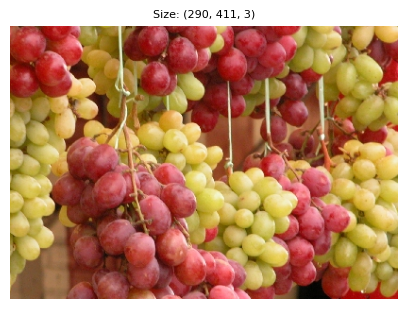

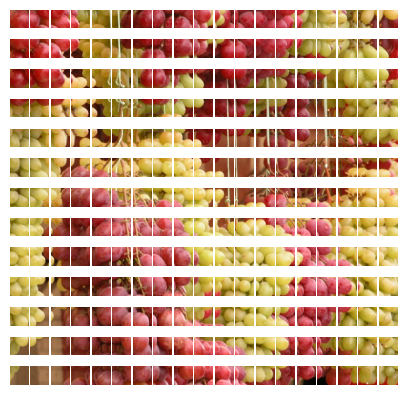

In [39]:
np.random.seed(42)

hr_img_paths = list(os.listdir(hr_train_path))
patch_size = (33, 33)

# Select random index and plot image along with patches
idx = int(np.random.randint(0, len(hr_img_paths), 1))
random_img_path = os.path.join(hr_train_path, hr_img_paths[idx])

plot_image_with_all_patches(random_img_path, patch_size, stride)

# 4.0 Loading Images data with custom 'Dataset'

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directories(the directory we'd like to get data from) as well as a transfrom if we'd like to transform out data
3. Create several attribute:
  * lr and hr path of our images
  * tranform - The transfrom we'd like to use
4. Create a function to `load_image()`, this function will open the image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

### 4.0.1 Transform for No Blurring(From Author)

In [40]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List

class SRCNN(Dataset):

  # 2. Initialize with a lr/hr_img_dir and transform(optional) parameter
  def __init__(self, lr_img_dir : str, hr_img_dir : str, ext : str,transform = None):

    # 3. Create class attributes
    self.img_paths = sorted(list(Path(lr_img_dir).glob(f"*.{ext}")))
    self.label_paths = sorted(list(Path(hr_img_dir).glob(f"*.{ext}")))

    # Setup transform
    self.transform = transform


  # Make function to load images
  def load_target(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    target_path = self.img_paths[idx]
    return Image.open(target_path)

  def load_label(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    label_path = self.label_paths[idx]
    return Image.open(label_path)

  # Overwrite the __len()__ method
  def __len__(self)-> int:

    "Returns the total number of samples."
    return len(self.img_paths)

  def __getitem__(self, idx : int) -> Tuple[torch.tensor, torch.tensor]:

    """Returns one sample of data, data and label (X, y)"""
    img = self.load_target(idx)
    target = self.load_label(idx)

    # Transform if necessary
    if self.transform:
      img = self.transform(img)
      target = self.transform(target)

    return img, target # return data, label (X, y)

In [41]:
def rgb_to_ycrcb(img: Image.Image) -> Image.Image:
    """
    Convert an RGB image to YCrCb and extract the Y channel.
    """
    if not isinstance(img, Image.Image):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    ycrcb_img = img.convert('YCbCr')
    y, _, _ = ycrcb_img.split()
    return y

In [42]:
from torchvision import transforms
# Augment train data
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

validation_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    rgb_to_ycrcb,
    transforms.ToTensor()
])

In [43]:
train_imgs = '../Data/Train/pLR'
train_labels = '../Data/Train/pHR'

val_imgs = '../Data/Validation/pLR'
val_labels = '../Data/Validation/pHR'

# test_imgs = 'SRCNN/Data/Test/LR'
# test_labels = 'SRCNN/Data/Test/HR'

train_data_custom = SRCNN(lr_img_dir = train_imgs,
                          hr_img_dir = train_labels,
                          ext = "png",
                          transform = train_transform)

validation_data_custom = SRCNN(lr_img_dir = val_imgs,
                          hr_img_dir = val_labels,
                          ext = "png",
                          transform = validation_transform)

# test_data_custom = SRCNN(lr_img_dir = test_imgs,
#                          hr_img_dir = test_labels,
#                          ext = "bmp",
#                          transform = test_transform)

train_data_custom, validation_data_custom

(<__main__.SRCNN at 0x7fb8b33cce50>, <__main__.SRCNN at 0x7fb8b3431d60>)

In [44]:
print(f"Length of Training Data: {len(train_data_custom)}")
print(f"Length of Training Data: {len(validation_data_custom)}")
# print(f"Length of Test Data: {len(test_data_custom)}")

Length of Training Data: 21884
Length of Training Data: 7731


## 4.1 Turn custom loaded images into DataLoader's

### 4.1.1 Collate function

In [45]:
import torch
from torch.nn.functional import pad

def custom_collate_fn(batch):


  # Find the largest image size in the batch
  max_height = max([item[0].size(1) for item in batch])
  max_width = max([item[0].size(2) for item in batch])

  batch_imgs = []
  batch_labels = []

  for(img, label) in batch:
    # Calculate padding size
    height_pad = max_height - img.size(1)
    width_pad = max_width - img.size(2)

    # Pad the image and label tensors to have the same size
    # Adjust padding as needed for your dataset (e.g., you might want symmetric padding)
    img_padded = pad(img, (0, width_pad, 0, height_pad))
    label_padded = pad(label, (0, width_pad, 0, height_pad))

    batch_imgs.append(img_padded)
    batch_labels.append(label_padded)

  # Stack all images and labels to form a batch
  batch_imgs = torch.stack(batch_imgs)
  batch_labels = torch.stack(batch_labels)


  return batch_imgs, batch_labels

In [46]:
import os
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64

# Split the validation dataset(Too big validation)
validation_size = int(1.0 * len(validation_data_custom))  # 50% for validation
rest_validation_size = len(validation_data_custom) - validation_size
validation_dataset = random_split(validation_data_custom, [rest_validation_size, validation_size])

# training_size = len(train_data_custom) - validation_size  # Remaining for training
# train_dataset, validation_dataset = random_split(train_data_custom, [training_size, validation_size])

# Create dataloaders for each set
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     num_workers=os.cpu_count(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

validation_dataloader_custom = DataLoader(dataset=validation_data_custom,
                                          num_workers=os.cpu_count(),
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

# test_dataloader_custom = DataLoader(dataset=test_data_custom,
#                                     num_workers=os.cpu_count(),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=False,
#                                     collate_fn=custom_collate_fn)  # Use the custom collate function

train_dataloader_custom, validation_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fb8b2395490>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb8b9055b20>)

In [47]:
# Get first batch of image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out shape
print(f"Image Batch shape: {img_custom.shape} ->[batch_size, color_channel, height, width]")
print(f"Label Shape: {label_custom.shape}")

Image Batch shape: torch.Size([64, 1, 33, 33]) ->[batch_size, color_channel, height, width]
Label Shape: torch.Size([64, 1, 19, 19])


## 4.2 Create a function to display random images

1. Take `Dataset` and `n` number of images to display
2. To prevent display getting out of hand, we'll cap `n` to 10 iamges
3. Set the random seed
4. Get a list of random indexes for plotting
5. Setup `matplotlib` plot
6. Loop through random list of index found in Step : 4  and plot them with `matplotlib`
7. Make sure the images are of right shape before we plot them.

In [48]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n is high
  if n > 5:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")


  if seed:
    torch.manual_seed(seed)

  # 3. Get random sample of indexes
  random_samples_idx = torch.randint(0, len(dataset), size=([1, n])).tolist()[0]

  # 4. Setup plot
  plt.figure(figsize=(6,18))

  # 5. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample]

    # 6. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channel]
    targ_img = targ_img.permute(1, 2, 0)
    targ_label = targ_label.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(targ_img, cmap="gray")
    if display_shape:
      plt.title(f"LR Image\nSize: {targ_img.shape}", fontsize = 8)
      mse_val = custom_mse_loss(targ_img.numpy(), targ_label.numpy())
      psnr_val = custom_psnr(targ_img.numpy(), targ_label.numpy())
      metrics_str = f"MSE: {mse_val:.2f}\n PSNR: {psnr_val:.2f} dB\n"
      plt.xlabel(metrics_str, fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(targ_label, cmap="gray")
    if display_shape:
      plt.title(f"HR Image\nSize: {targ_label.shape}", fontsize = 8)
    plt.xticks([])
    plt.yticks([])

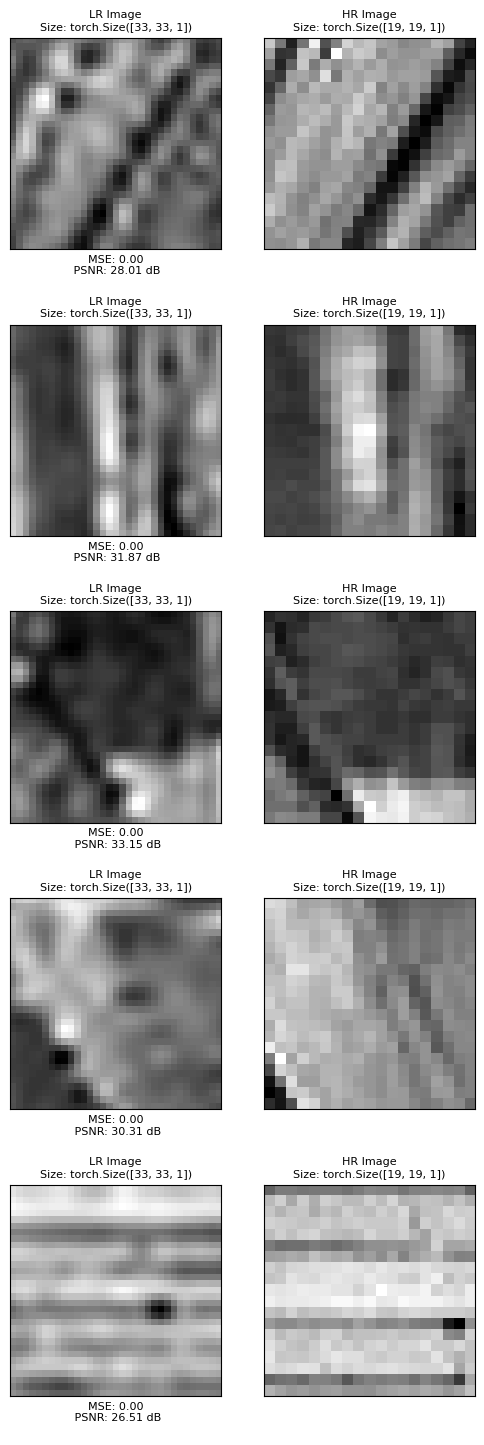

In [49]:
# Display random images from custom created Dataset
display_random_images(dataset=train_data_custom,
                      n=5,
                      seed=None)

# 5.0 Model : SRCNN w/o Data Augmentation

Let's replicate SRCNN architecture from paper https://arxiv.org/pdf/1501.00092.pdf

## 5.1 SRCNN Model(9-x-5) Class

In [50]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
import torch
import torch.nn as nn
import torch.nn.init as init

class SRCNNModel(nn.Module):

  """
  Model architecture(9-3-5) from original paper
  """

  def __init__(self, input_shape: int,
               hidden_units_1: int,
               hidden_units_2: int,
               kernel_sizes: list,
               output_shape: int) -> None:

    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units_1,
                  kernel_size=kernel_sizes[0],
                  padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units_1,
                  out_channels=hidden_units_2,
                  kernel_size=kernel_sizes[1],
                  padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU()
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units_2,
                  out_channels=output_shape,
                  kernel_size=kernel_sizes[2],
                  padding=0)
    )
    self._intialize_weights()


  def _intialize_weights(self):

    for layer in self.modules():
      if isinstance (layer, nn.Conv2d):
        init.normal_(layer.weight, mean=0.0, std=0.001)
        if layer.bias is not None:
          init.zeros_(layer.bias)

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    return x

### 5.1.1 Sample Model(9-x-5)

In [52]:
torch.manual_seed(42)
model_0 = SRCNNModel(input_shape=1,
                   hidden_units_1=64,
                   hidden_units_2=32,
                   kernel_sizes=arch,
                   output_shape=1).to(device)

model_0

SRCNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

## 5.2 Try a forward pass on a single image(to test the model)

In [ ]:
# Get a single batch of images
img_batch, label_batch = next(iter(train_dataloader_custom))
img_batch.shape, label_batch.shape

## 5.3 Use `torchinfo` to get an idea of the shapes going through our model

In [54]:
from torchinfo import summary
summary(model_0, input_size=[1, 1, 33, 33])

Layer (type:depth-idx)                   Output Shape              Param #
SRCNNModel                               [1, 1, 19, 19]            --
├─Sequential: 1-1                        [1, 32, 23, 23]           --
│    └─Conv2d: 2-1                       [1, 64, 25, 25]           5,248
│    └─ReLU: 2-2                         [1, 64, 25, 25]           --
│    └─Conv2d: 2-3                       [1, 32, 23, 23]           18,464
│    └─ReLU: 2-4                         [1, 32, 23, 23]           --
├─Sequential: 1-2                        [1, 1, 19, 19]            --
│    └─Conv2d: 2-5                       [1, 1, 19, 19]            801
Total params: 24,513
Trainable params: 24,513
Non-trainable params: 0
Total mult-adds (M): 13.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.10
Estimated Total Size (MB): 0.56

## 5.4 Create train and test loop function

* `train_step()` - Takes in model and dataloader and trains the model on the dataloader

* `test_step()` - Take in model and dataloader and evaluatest the model on the dataloader

In [55]:
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: str,
               max_pixel_value: float = 1.0) -> (float, float):
    """
    Performs a single training step including forward pass, loss computation,
    backpropagation, and optimizer step.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    - loss_fn: Loss function used for training.
    - optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
    - device (str): Device to run the training on ('cuda' or 'cpu').
    - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

    Returns:
    - train_loss (float): Average training loss for this step.
    - train_psnr (float): Average Peak Signal-to-Noise Ratio (PSNR) for this step.

    Raises:
    - ValueError: If `device` is not 'cuda' or 'cpu'.
    - TypeError: If the provided model, dataloader, loss function, or optimizer are of the wrong type.
    """

    # Validate input parameters for type and value
    if not isinstance(model, torch.nn.Module):
        raise TypeError("model must be an instance of torch.nn.Module")
    if not isinstance(dataloader, torch.utils.data.DataLoader):
        raise TypeError("dataloader must be an instance of torch.utils.data.DataLoader")
    if not callable(loss_fn):
        raise TypeError("loss_fn must be callable")
    if not isinstance(optimizer, torch.optim.Optimizer):
        raise TypeError("optimizer must be an instance of torch.optim.Optimizer")
    if device not in ['cuda', 'cpu']:
        raise ValueError("device must be 'cuda' or 'cpu'")

    # Ensure model is on the correct device
    model.to(device)

    # Put the model in train mode
    model.train()

    # Setup train loss and PSNR
    train_loss = 0.0
    train_psnr = 0.0

    # Loop through batches of data
    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate PSNR
        psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
        train_psnr += psnr.item()

    # Adjust metrics to get average loss and PSNR per batch
    train_loss /= len(dataloader)
    train_psnr /= len(dataloader)

    return train_loss, train_psnr


In [56]:
import torch

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              device: str,
              max_pixel_value: float = 1.0) -> (float, float):
    """
    Performs a single evaluation step, calculating the average loss and PSNR
    over the provided dataloader.

    Parameters:
    - model (torch.nn.Module): The neural network model to be evaluated.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
    - loss_fn: The loss function used for evaluation.
    - device (str): The device to run the evaluation on ('cuda' or 'cpu').
    - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

    Returns:
    - test_loss (float): The average loss over the dataloader.
    - test_psnr (float): The average Peak Signal-to-Noise Ratio over the dataloader.

    Raises:
    - ValueError: If `device` is not 'cuda' or 'cpu'.
    - TypeError: If the provided model, dataloader, loss function, or device are of the wrong type.
    """

    # Validate input parameters
    if not isinstance(model, torch.nn.Module):
        raise TypeError("model must be an instance of torch.nn.Module")
    if not isinstance(dataloader, torch.utils.data.DataLoader):
        raise TypeError("dataloader must be an instance of torch.utils.data.DataLoader")
    if not callable(loss_fn):
        raise TypeError("loss_fn must be callable")
    if device not in ['cuda', 'cpu']:
        raise ValueError("device must be 'cuda' or 'cpu'")

    # Ensure model is on the correct device
    model.to(device)

    # Put the model in eval mode
    model.eval()

    test_loss = 0.0
    test_psnr = 0.0

    with torch.inference_mode():
        for _, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate PSNR
            psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
            test_psnr += psnr.item()

    # Compute average loss and PSNR
    test_loss /= len(dataloader)
    test_psnr /= len(dataloader)

    return test_loss, test_psnr


## 5.5 Checkpoint Saving Function

In [57]:
import torch
import os

def save_checkpoint(epoch, model, optimizer, loss, path="checkpoint.pth"):
    """
    Saves a checkpoint of the model and optimizer state.

    Parameters:
    - epoch: The current epoch number.
    - model: The model being trained.
    - optimizer: The optimizer being used for training.
    - loss: The loss value at the checkpoint.
    - path: The path to save the checkpoint to.
    """
    checkpoint = {
        'epoch': epoch + 1,  # Saving such that training can resume from the next epoch
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at '{path}'")

## 5.6 Early Stopping and Best Model Saving

In [58]:
class EarlyStopping:

  def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pth'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.counter = 0
    self.path = path

  def __call__(self, val_loss, model, optimizer):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
          print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
      self.counter = 0

  def save_checkpoint(self, val_loss, model, optimizer):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, self.path)
    self.val_loss_min = val_loss

## 5.7 Creating a `train()` function to combine `train_step()` and `test_step()`

In [59]:
import os
import time
import wandb
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn,
          path: str,
          start_epoch: int = 0,
          end_epoch: int = 200,
          checkpoint_interval=20,
          device: str = device):

  # Start the timer
  start_time = time.time()

  # 2. Create a empty result dicitonary
  results = {'train_loss': [],
            'val_loss' : [],
            'train_psnr': [],
            'val_psnr': []}

  # 3. Directory to save the model
  if not (os.path.exists("/home/mpershad/Documents/Python/SRCNN/Models")):
    os.makedirs("/home/mpershad/Documents/Python/SRCNN/Models")

  model_path = f"/home/mpershad/Documents/Python/SRCNN/Models/{path}.pth"

  early_stopper = EarlyStopping(patience=300, verbose=False, path=model_path)

  total_epochs = end_epoch - start_epoch
  log_interval = total_epochs // 10 if total_epochs // 10 > 0 else 1

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(start_epoch, end_epoch)):

    train_loss, train_psnr = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)

    val_loss, val_psnr = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["train_psnr"].append(train_psnr)
    results["val_psnr"].append(val_psnr)

    # Log PSNR values
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_psnr': train_psnr, 'val_psnr': val_psnr})

    # Log values every 10% of the total epochs
    if epoch % log_interval == 0 or epoch == end_epoch - 1:
      
      # Print out what's happening
      print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | train_psnr: {train_psnr:.2f} dB | val_psnr: {val_psnr:.2f} dB")

    early_stopper(val_loss, model, optimizer)
    if early_stopper.early_stop:
      print("Early stopping")
      break

    # Checkpoint Saving
    if epoch % checkpoint_interval == 0 or epoch == end_epoch - 1:
      checkpoint_path = f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}/epoch_{epoch}.pth"

      if not (os.path.exists(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}")):
        os.makedirs(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}")

      save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, loss=val_loss, path=checkpoint_path)
      # Optionally log checkpoint to wandb
      wandb.save(checkpoint_path)

  # 6. Use wandb.save() to ensure the model file is saved to W&B
  wandb.save(model_path)

  # 7. Log the model as an artifact
  artifact = wandb.Artifact('SRCNNModel', type='model', description="A super-resolution model")
  artifact.add_file(model_path)
  wandb.log_artifact(artifact)

  # 9. Calculate and log training duration
  end_time = time.time()
  total_training_time = end_time - start_time
  wandb.log({'total_training_time': total_training_time})

  # 10. Print the training time
  print(f"Total training time: {total_training_time:.3f} seconds")

  # 11. Remember to finish the W&B run
  wandb.finish()

  # 12. Return the results dict
  return results

## 5.8 Plot Loss Curves

A loss curve is a way of tracking your model's progress over time

In [60]:
def plot_loss_curves(results):
    """Plot training and validation loss curves and PSNR curves."""
    # Extract values from the results dictionary
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    train_psnr = results['train_psnr']
    val_psnr = results['val_psnr']

    # Calculate min and max values for loss and PSNR to dynamically set plot ranges
    min_loss = min(train_loss + val_loss)
    max_loss = max(train_loss + val_loss)
    min_psnr = min(train_psnr + val_psnr)
    max_psnr = max(train_psnr + val_psnr)

    # Setup the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Loss
    ax1.plot(train_loss, label='Training Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='red')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_ylim([min_loss - 0.05 * (max_loss - min_loss), max_loss + 0.05 * (max_loss - min_loss)])
    ax1.legend()

    # Plot PSNR
    ax2.plot(train_psnr, label='Training PSNR', color='blue')
    ax2.plot(val_psnr, label='Validation PSNR', color='red')
    ax2.set_title('PSNR Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('PSNR (dB)')
    ax2.set_ylim([min_psnr - 0.05 * (max_psnr - min_psnr), max_psnr + 0.05 * (max_psnr - min_psnr)])
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 6.0 Tracking experiments

In [61]:
import os

# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

In [62]:
import wandb

# Log in to your W&B account
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: pershadmayank. Use `wandb login --relogin` to force relogin


True

## 6.1 Config

In [63]:
# Initialize a W&B run
import wandb
wandb.init(project='SRCNN', entity='pershadmayank', config={
    'start_epoch': 0,
    'end_epoch': 3000,
    'learning_rate_first_two_layers': 4e-4,
    'learning_rate_last_layer': 4e-5,
    'architecture': 'SRCNN',
    'kernel_sizes': arch,
    'hidden_units_1': 64,
    'hidden_units_2': 32,
    'input_shape': 1,
    'output_shape': 1,
    'checkpoint_interval': 300  # Added to config for flexibility
})

## 6.2 Setup Loss function and optimizer

In [64]:
import torch.nn as nn
import torch

# Set the random seed for reproducibility
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Access hyperparameters from wandb.config
config = wandb.config

# Recreate an instance of SRCNN Model using the wandb config
model_0 = SRCNNModel(input_shape=config.input_shape,
                     hidden_units_1=config.hidden_units_1,
                     hidden_units_2=config.hidden_units_2,
                     kernel_sizes=config.kernel_sizes,
                     output_shape=config.output_shape).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model_0.conv_block_1.parameters())
last_layer_params = list(model_0.conv_block_2.parameters())

# Setup the optimizer with learning rates from wandb.config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config.learning_rate_first_two_layers},
    {'params': last_layer_params, 'lr': config.learning_rate_last_layer}
])

# Setup the loss function
loss_fn = nn.MSELoss()

In [65]:
model_name = str(input("Enter model name:"))

In [66]:
# Train the model using the wandb.config values
model_0_results = train(model=model_0,
                      train_dataloader=train_dataloader_custom,
                      test_dataloader=validation_dataloader_custom,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      path=model_name,
                      start_epoch=config.start_epoch,
                      end_epoch=config.end_epoch,
                      device=device,
                      checkpoint_interval=config.checkpoint_interval)

  0%|          | 1/3000 [00:06<5:27:42,  6.56s/it]

Epoch: 1 | train_loss: 0.0198 | val_loss: 0.0063 | train_psnr: 20.80 dB | val_psnr: 23.40 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model11_9_3_5/epoch_0.pth'


 10%|█         | 301/3000 [34:11<5:23:47,  7.20s/it]

Epoch: 301 | train_loss: 0.0027 | val_loss: 0.0033 | train_psnr: 25.75 dB | val_psnr: 26.86 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model11_9_3_5/epoch_300.pth'


 20%|██        | 601/3000 [1:10:30<4:58:27,  7.46s/it]

Epoch: 601 | train_loss: 0.0026 | val_loss: 0.0032 | train_psnr: 25.88 dB | val_psnr: 26.93 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model11_9_3_5/epoch_600.pth'


 30%|███       | 901/3000 [1:46:48<4:06:26,  7.04s/it]

Epoch: 901 | train_loss: 0.0026 | val_loss: 0.0032 | train_psnr: 25.94 dB | val_psnr: 26.92 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model11_9_3_5/epoch_900.pth'


 40%|████      | 1201/3000 [2:23:17<3:40:52,  7.37s/it]

Epoch: 1201 | train_loss: 0.0026 | val_loss: 0.0032 | train_psnr: 25.97 dB | val_psnr: 26.92 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model11_9_3_5/epoch_1200.pth'


 49%|████▉     | 1472/3000 [2:56:21<3:03:03,  7.19s/it]

Early stopping


Total training time: 10581.738 seconds


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_training_time,▁
train_loss,█▇▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_psnr,▁▂▂▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇██████████████████
val_loss,█▇▇▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_psnr,▁▁▂▅▆▆▅▇▇▇▇▇▇▇██▇█▇████████████████████▇
epoch,1472
total_training_time,10581.73823
train_loss,0.00257
train_psnr,25.97546
val_loss,0.0032


## 6.3 Save Results Dictionary

In [67]:
import pickle
import os

metrics_path = f'../Metrics'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

pickle_file_path = os.path.join(metrics_path, f"metrics_{model_name}.pkl")


with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_0_results, file)

print(f"Results saved to {pickle_file_path}")

Results saved to ../Metrics/metrics_model11_9_3_5.pkl


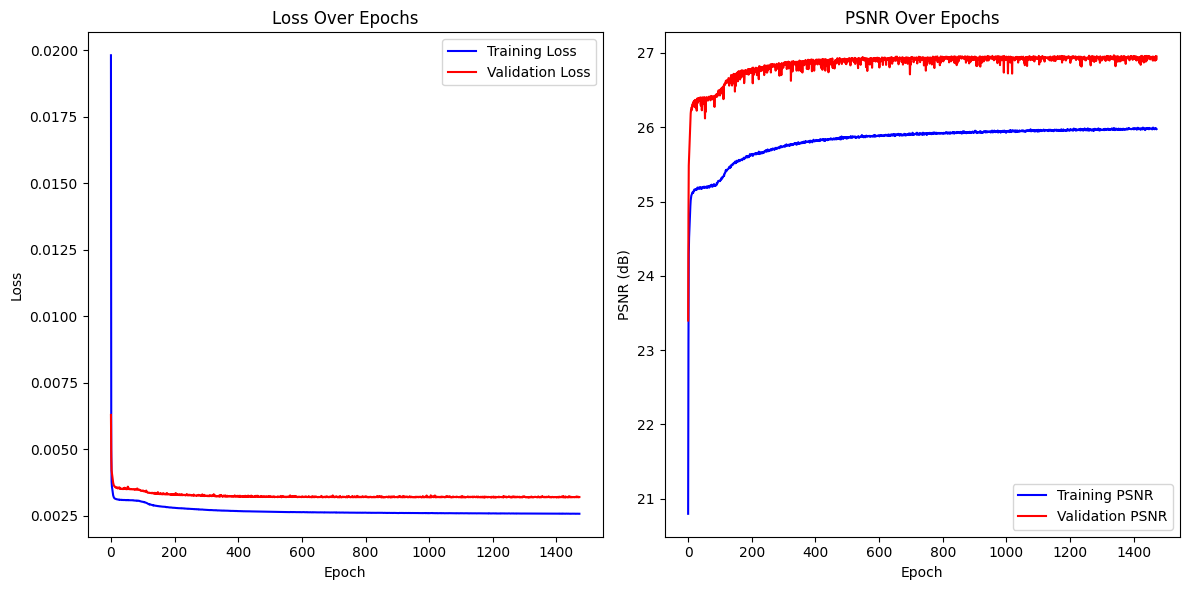

In [68]:
plot_loss_curves(model_0_results)

# 7.0 Resuming the model training from checkpoint


1.  Log In into wandb
2.  Connet to specific project run instance using `wandb.Api()`
3.  Dowload the checkpoint files using `run.files()`
4.  Get the latest checkpoint
5.  Load the latest checkpoint
6.  Get the config.yaml file
7.  Parse the yaml files and the configs
8.  Setup the model, optmizier, loss_fn and epoch according to config
9.  Resume/Continue training the model




In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!pip install wandb

In [ ]:
!export WANDB_API_KEY='0736c590933a18ad9639f49867ed1548495ded1c'

## 7.1 Log In

In [ ]:
import wandb

project_name = "SRCNN"
entity_name = "pershadmayank"

# Initialize W&B web client
api = wandb.Api()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 7.2 Connect to the specific project run

In [ ]:
# Define the wandb entity and project
project_name = "SRCNN"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity
run_id = input("Enter runtime ID: ")  # replace with the run ID you want to download from

# Get the specific run
run = api.run(f"{entity_name}/{project_name}/{run_id}")

Enter runtime ID: yaukx79p


## 7.3 Download the checkpoints

In [ ]:
import os
import wandb

# List all files in the root directory of the run
root_files = run.files()

# Define the directory where you want to save the checkpoints
checkpoint_dir = 'Checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Download the specific checkpoint files
for file in root_files:
    if file.name.startswith("model") and file.name.endswith(".pth"):
        download_path = os.path.join(checkpoint_dir, file.name)
        file.download(root=checkpoint_dir, replace=True)  # Set replace=True to overwrite existing files
        print(f"Downloaded {file.name} to {download_path}")

print("All checkpoint files have been downloaded to the specified folder.")

Downloaded model1_9_3_5_epoch_0.pth to Checkpoints/model1_9_3_5_epoch_0.pth
Downloaded model1_9_3_5_epoch_100.pth to Checkpoints/model1_9_3_5_epoch_100.pth
Downloaded model1_9_3_5_epoch_150.pth to Checkpoints/model1_9_3_5_epoch_150.pth
Downloaded model1_9_3_5_epoch_199.pth to Checkpoints/model1_9_3_5_epoch_199.pth
Downloaded model1_9_3_5_epoch_50.pth to Checkpoints/model1_9_3_5_epoch_50.pth
All checkpoint files have been downloaded to the specified folder.


In [ ]:
import re

def find_latest_checkpoint(checkpoint_files):
    # Regular expression to extract the epoch number from the filename
    epoch_regex = re.compile(r"epoch_(\d+)\.pth")

    # Dictionary to hold filename and corresponding epoch number
    checkpoints = {}

    # Iterate over the file list and extract epoch numbers
    for filename in checkpoint_files:
        match = epoch_regex.search(filename)
        if match:
            # Convert the epoch number to an integer for comparison
            epoch_num = int(match.group(1))
            checkpoints[epoch_num] = filename

    # Find the highest epoch number, which corresponds to the latest checkpoint
    latest_epoch = max(checkpoints.keys())
    latest_checkpoint = checkpoints[latest_epoch]

    return latest_epoch, latest_checkpoint

In [ ]:
# Assuming you have the checkpoint path
latest_epoch, latest_checkpoint_path = find_latest_checkpoint(os.listdir('Checkpoints'))
latest_checkpoint_path = os.path.join('Checkpoints', latest_checkpoint_path)
latest_epoch, latest_checkpoint_path

(199, 'Checkpoints/model1_9_3_5_epoch_199.pth')

## 7.4 Load the checkpoint

In [ ]:
import torch

def load_checkpoint(model, optimizer, path):
    """
    Loads the checkpoint into the model and optimizer.
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

## 7.5 Download the config

In [ ]:
# Download the config.yaml file
config_file = run.file("config.yaml")
config_path = "Config/config.yaml"  # specify your desired path
config_file.download(root="Config", replace=True)

<_io.TextIOWrapper name='Config/config.yaml' mode='r' encoding='UTF-8'>

In [ ]:
!pip install pyyaml

In [ ]:
import yaml

# Load the configuration
with open("Config/config.yaml", 'r') as file:
    config_data = yaml.safe_load(file)

## 7.6 Parse the config

In [ ]:
# Resume the wandb run
wandb.init(project=project_name, entity=entity_name, id=run_id, resume="allow", config=config_data)

wandb: Currently logged in as: pershadmayank. Use `wandb login --relogin` to force relogin


In [ ]:
import torch

# Parsing only the relevant configuration and ignoring metadata or other non-relevant keys
config = {k: v['value'] for k, v in config_data.items() if isinstance(v, dict) and 'value' in v}
config['start_epoch'] = latest_epoch

# Now you can access the configuration values directly
# Recreate an instance of SRCNN Model using the parsed config
model_0 = SRCNNModel(input_shape=config['input_shape'],
                     hidden_units_1=config['hidden_units_1'],
                     hidden_units_2=config['hidden_units_2'],
                     kernel_sizes=config['kernel_sizes'],
                     output_shape=config['output_shape']).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model_0.conv_block_1.parameters())
last_layer_params = list(model_0.conv_block_2.parameters())

# Setup the optimizer with learning rates from the parsed config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config['learning_rate_first_two_layers']},
    {'params': last_layer_params, 'lr': config['learning_rate_last_layer']}
])

# Setup the loss function
loss_fn = custom_mse_loss

## 7.5 Load the model, optimizer and loss

In [ ]:
# Load the model and optimizer (make sure to define these before this step)
model, optimizer, start_epoch, loss = load_checkpoint(model_0, optimizer, latest_checkpoint_path)

## 7.6 Resume training

In [ ]:
EPOCHS = int(input("Epochs to train more: "))

config['end_epoch'] = int(config['start_epoch']) + EPOCHS

Epochs to train more: 50


In [ ]:
# Train the model for the remaining epochs
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=validation_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        path=model_name,
                        start_epoch=latest_epoch,  # Train only for the remaining epochs
                        end_epoch=latest_epoch + EPOCHS,
                        device=device,
                        checkpoint_interval=config.checkpoint_interval)

# 8.0 Loading Pre-Trained Model

In [69]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [70]:
import os

# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

## 8.1 Log In

In [71]:
import wandb

# Initialize W&B web client
api = wandb.Api()

## 8.2 Connect to the specific project run

In [72]:
# Define the wandb entity and project
project_name = "SRCNN"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity
run_id = input("Enter runtime ID: ")  # replace with the run ID you want to download from

# Get the specific run
run = api.run(f"{entity_name}/{project_name}/{run_id}")

## 8.3 Download the config

In [73]:
# Download the config.yaml file
config_file = run.file("config.yaml")
config_path = "Config/config.yaml"  # specify your desired path
config_file.download(root="Config", replace=True)

<_io.TextIOWrapper name='Config/config.yaml' mode='r' encoding='UTF-8'>

In [74]:
import yaml

# Load the configuration
with open("Config/config.yaml", 'r') as file:
    config_data = yaml.safe_load(file)

## 8.4 Parse the config

In [ ]:
# Resume the wandb run if want to retrain the model
# wandb.init(project=project_name, entity=entity_name, id=run_id, resume="allow", config=config_data)

In [75]:
config = {}
for k,v in config_data.items():
  if isinstance(v, dict) and 'value' in v:
    config[k] = v['value']
    # if isinstance(v['value'], dict) and 'value' in v['value']:
    #   config[k] = v['value']['value']
    #   if isinstance(v['value']['value'], dict) and 'value' in v['value']:
    #     config[k] = v['value']['value']['value']


In [76]:
import torch

# Now you can access the configuration values directly
# Recreate an instance of SRCNN Model using the parsed config
model = SRCNNModel(input_shape=config['input_shape'],
                     hidden_units_1=config['hidden_units_1'],
                     hidden_units_2=config['hidden_units_2'],
                     kernel_sizes=config['kernel_sizes'],
                     output_shape=config['output_shape']).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model.conv_block_1.parameters())
last_layer_params = list(model.conv_block_2.parameters())

# Setup the optimizer with learning rates from the parsed config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config['learning_rate_first_two_layers']},
    {'params': last_layer_params, 'lr': config['learning_rate_last_layer']}
])

# Setup the loss function
loss_fn = custom_mse_loss

In [78]:
# Get the artifact using the API
artifact = api.artifact("pershadmayank/SRCNN/SRCNNModel:v15", type="model")

# Use the artifact in your current run
run = wandb.init()
artifact_obj = run.use_artifact(artifact)

# Download the artifact's contents
artifact_dir = artifact_obj.download()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb:   1 of 1 files downloaded.  


In [81]:
import os
import glob

# Assuming artifact_dir is the directory where the artifact is downloaded
model_path = glob.glob(os.path.join(artifact_dir, "*.pth"))

if not model_path:
    raise FileNotFoundError("No .pth file found in the artifact directory.")

model_path[0]

'/home/mpershad/Documents/Python/SRCNN/Code/artifacts/SRCNNModel:v15/model11_9_3_5.pth'

In [82]:
# Load the checkpoint
checkpoint = torch.load(model_path[0], map_location=device)  # or 'cuda' if using GPU

# Apply the loaded state dictionaries to the model and optimizer
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to the desired device
model.to(device)

SRCNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

# 9.0 Inference using trained Model


In [83]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# /content/SRCNN/Data/Test/LR/baboon.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Test/HR/baboon.bmp"

# Convert BMP to JPEG or PNG
hr_img = Image.open(test_img_path).convert('RGB')

hr_img_ycbcr = hr_img.convert('YCbCr')

# Convert images to numpy arrays
hr_img_array = np.array(hr_img_ycbcr)

hr_img_array = modcrop(hr_img_array, scale)

# Take the y channel
y_channel = hr_img_array[:, :, 0]

test_img = generate_lr_image(y_channel, operation, scale, kernel_size, sigma)

# Convert the Y channel image to a PyTorch tensor
test_img_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Convert RGB to Y channel and get Image Tensor
test_img_tensor = test_img_transform(test_img)

# Move the tensor to the designated device
test_img_tensor = test_img_tensor.to(device)

# Print out image data
print(f"Test Image Tesnor:\n {test_img_tensor}\n")
print(f"Test Image Shape: {test_img_tensor.shape}")
print(f"Test Image stype: {test_img_tensor.dtype}")

Test Image Tesnor:
 tensor([[[0.6314, 0.5843, 0.4392,  ..., 0.6235, 0.6471, 0.6588],
         [0.5843, 0.5412, 0.4078,  ..., 0.5961, 0.5961, 0.6039],
         [0.4471, 0.4157, 0.3137,  ..., 0.5255, 0.4549, 0.4353],
         ...,
         [0.3373, 0.3451, 0.3647,  ..., 0.1765, 0.1686, 0.1686],
         [0.3137, 0.3255, 0.3529,  ..., 0.1843, 0.1725, 0.1686],
         [0.3059, 0.3176, 0.3490,  ..., 0.1882, 0.1725, 0.1686]]],
       device='cuda:0')

Test Image Shape: torch.Size([1, 480, 498])
Test Image stype: torch.float32


In [84]:
test_img_tensor.shape, test_img_tensor.unsqueeze(dim=0).shape

(torch.Size([1, 480, 498]), torch.Size([1, 1, 480, 498]))

In [85]:
# Set it to evaluation mode
model.eval()
with torch.inference_mode():
  y_predicted = model(test_img_tensor.unsqueeze(dim=0).to(device))

In [86]:
y_predicted.shape

torch.Size([1, 1, 466, 484])

In [87]:
import numpy as np

def crop(original_img, target_height, target_width):
  """
  Crop the central region of the image to match the target height and width.
  """
  orig_height, orig_width = original_img.shape[:2]
  start_x = (orig_width - target_width) // 2
  start_y = (orig_height - target_height) // 2
  return original_img[start_y:start_y + target_height, start_x:start_x + target_width]

In [88]:
# test_img = test_img.convert('YCbCr')
y, Cb, Cr = hr_img_ycbcr.split()

# Process the output
y_predicted = y_predicted.squeeze().cpu().numpy() * 255
y_predicted = y_predicted.astype(np.uint8)

# # Convert Cb and Cr to numpy for cropping
# y = np.array(y).astype(np.uint8)
# Cb = np.array(Cb).astype(np.uint8)
# Cr = np.array(Cr).astype(np.uint8)

# Crop Y, Cb and Cr channels to match the predicted Y size
target_height, target_width = y_predicted.shape[:2]
y = crop(hr_img_array[:, :,  0], target_height, target_width)
Cb = crop(hr_img_array[:, :,  1], target_height, target_width)
Cr = crop(hr_img_array[:, :,  2], target_height, target_width)

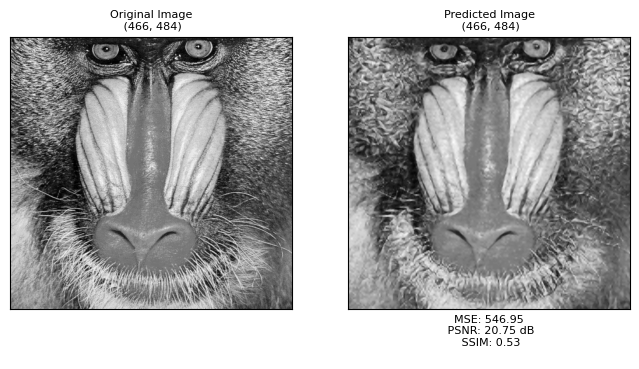

In [90]:
import matplotlib.pyplot as plt

# Calculate the combined metrics
metrics = combined_metric(y, y_predicted.squeeze())
metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(y, cmap="gray")
plt.title(f"Original Image\n {y.shape}", fontsize=8)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(y_predicted, cmap="gray")
plt.title(f"Predicted Image\n {y_predicted.shape}", fontsize=8)
plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
plt.xticks([])
plt.yticks([])
plt.show()

In [91]:
import cv2 as cv

# Combine the cropped original channels into a YCbCr image
cropped_ycbcr = np.stack((y, Cb, Cr), axis=-1).astype(np.uint8)
predicted_ycbcr = np.stack((y_predicted.squeeze(), Cb, Cr), axis=-1).astype(np.uint8)
# Convert YCbCr to RGB
cropped_rgb = cv.cvtColor(cropped_ycbcr, cv.COLOR_YCrCb2BGR)
predicted_rgb = cv.cvtColor(predicted_ycbcr, cv.COLOR_YCrCb2BGR)

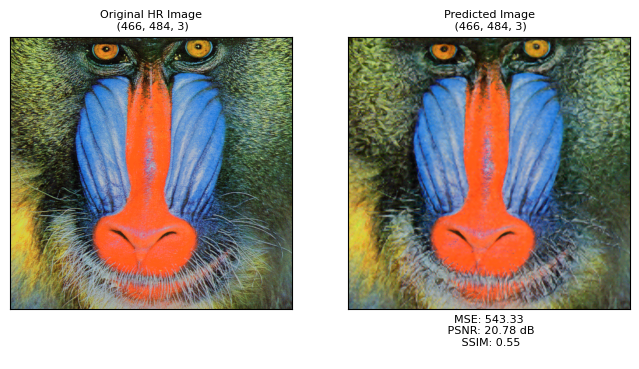

In [92]:
import matplotlib.pyplot as plt

# Calculate the combined metrics
metrics = combined_metric(cropped_rgb, predicted_rgb)
metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(cropped_rgb)
plt.title(f"Original HR Image\n {cropped_rgb.shape}", fontsize=8)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(predicted_rgb)
plt.title(f"Predicted Image\n {predicted_rgb.shape}", fontsize=8)
plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
plt.xticks([])
plt.yticks([])
plt.show()

**Note:** To make a prediction using the trained SRCNN model on a custom image:

1. Load the image using PIL and ensure it's in RGB format.
2. Convert the RGB image to YCbCr format and extract the Y channel.
3. Apply necessary transformations to the Y channel (e.g., resize, convert to tensor).
4. Add a batch dimension to the tensor to make it suitable for the model.
5. Set the model to evaluation mode using `model.eval()`.
6. Move the tensor to the same device as the model (if using GPU).
7. Pass the tensor through the model to get the predicted Y channel.
8. Resize the original Cb and Cr channels to match the predicted Y channel's dimensions (if necessary).
9. Merge the predicted Y channel with the resized Cb and Cr channels.
10. Convert the resulting YCbCr image back to RGB.
11. Visualize or save the resulting RGB image.

Ensure that all tensors are of the correct datatype (typically `torch.float32`) and that the preprocessing steps match those used during the model's training phase.


In [93]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2 as cv

def pred_and_plot_image(model: torch.nn.Module, image_path: str, transform=None, plot=False, device: torch.device = torch.device('cpu')):
  # Load image and convert
  hr_img = Image.open(image_path).convert('RGB')
  hr_img_ycbcr = hr_img.convert('YCbCr')
  hr_img_array = np.array(hr_img_ycbcr)

  hr_img_array = modcrop(hr_img_array, scale)

  y_channel = hr_img_array[:, :, 0]  # Take the Y channel
  test_img = generate_lr_image(y_channel, operation, scale, kernel_size, sigma)

  if transform is None:
    transform = transforms.Compose([transforms.ToTensor()])

  test_img_tensor = transform(test_img).to(device)

  # Inference
  model.eval()
  with torch.no_grad():
      y_predicted = model(test_img_tensor.unsqueeze(0))

  # Process the output
  y_predicted = y_predicted.squeeze().cpu().numpy() * 255
  y_predicted = y_predicted.astype(np.uint8)

  # Crop original channels to match the predicted Y size
  target_height, target_width = y_predicted.shape
  y, Cb, Cr = crop(hr_img_array[:, :, 0], target_height, target_width), \
              crop(hr_img_array[:, :, 1], target_height, target_width), \
              crop(hr_img_array[:, :, 2], target_height, target_width)

  # Combine and convert for plotting
  cropped_ycbcr = np.stack((y, Cb, Cr), axis=-1).astype(np.uint8)
  predicted_ycbcr = np.stack((y_predicted, Cb, Cr), axis=-1).astype(np.uint8)
  cropped_rgb = cv.cvtColor(cropped_ycbcr, cv.COLOR_YCrCb2BGR)
  predicted_rgb = cv.cvtColor(predicted_ycbcr, cv.COLOR_YCrCb2BGR)


  if plot:
    metrics = combined_metric(cropped_rgb, predicted_rgb)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_rgb)
    plt.title("Original HR Image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_rgb)
    plt.title("Predicted Image")
    plt.xlabel(metrics_str)
    plt.xticks([])
    plt.yticks([])
    plt.show()
  return cropped_rgb, predicted_rgb

In [94]:
# /content/SRCNN/Data/Test/LR/lenna.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Test/HR/lenna.bmp"

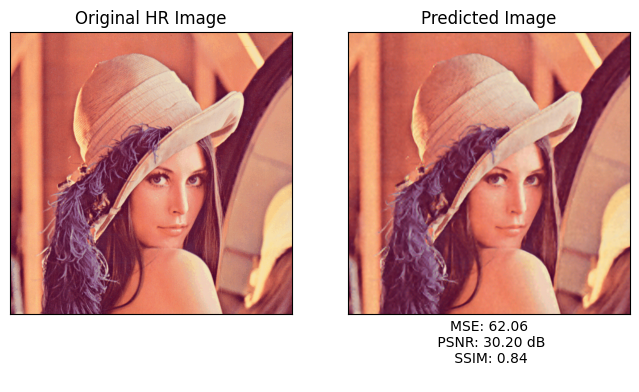

In [95]:
pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                image_path=test_img_path,  # Replace with the path to your image
                                transform=test_img_transform,  # The transformation to apply
                                device=device,  # The device (cpu or cuda)
                                plot=True)

In [96]:
from PIL import Image
import pandas as pd


# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Filename', 'MSE', 'PSNR', 'SSIM'])

# Instead of using append in a loop, collect your rows in a list
rows_to_add = []

test_img_dir = "../Data/Test/HR"
for f in os.listdir(test_img_dir):

  filename = f.split('.')[0]

  image_path = os.path.join(test_img_dir, f)

  # Get the predicted image
  cropped_img, predicted_img = pred_and_plot_image(model=model,
                                      image_path=os.path.join(test_img_dir, f),
                                      transform=test_img_transform,
                                      device=device,
                                      plot=False)

  # Compute metrics
  metrics = combined_metric(cropped_img, predicted_img)

  # Append the row as a dictionary to the list
  rows_to_add.append({'Filename': filename, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2]})

results_df = pd.concat([results_df, pd.DataFrame(rows_to_add)], ignore_index=True)

In [98]:
set5 = [0, 9, 12, 16, 18]
set5_df = results_df.iloc[set5].reset_index(drop=True)
avg_psnr =set5_df['PSNR'].mean()
print(f"Average PSNR: {avg_psnr:.2f}dB")
set5_df

Average PSNR: 29.17dB


,Filename,MSE,PSNR,SSIM
0,butterfly_GT,285.483348,23.574996,0.874448
1,woman_GT,108.570003,27.773705,0.897125
2,head_GT,54.316744,30.781466,0.778407
3,baby_GT,41.576660,31.942308,0.900860
4,bird_GT,43.009026,31.795207,0.942328


In [99]:
set14_df = results_df.drop(set5).reset_index(drop=True)
avg_psnr = set14_df['PSNR'].mean()
print(f"Average PSNR: {avg_psnr:.2f}dB")
set14_df

Average PSNR: 25.19dB


,Filename,MSE,PSNR,SSIM
0,ppt3,1493.033747,16.390107,0.768288
1,coastguard,275.901752,23.723259,0.580525
2,baboon,543.334094,20.780134,0.550490
3,zebra,358.099583,22.590765,0.772547
4,monarch,97.138278,28.256900,0.923161
5,face,54.174305,30.792870,0.777293
6,foreman,45.593259,31.541797,0.912432
7,barbara,290.031697,23.506349,0.746696
8,comic,503.524950,21.110594,0.717738
9,man,254.582243,24.072523,0.720303
